<a href="https://colab.research.google.com/github/thaisneubauer/PPAR2021/blob/main/BPI_Challenge_2012_01Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[BPI Challenge 2012](https://www.win.tue.nl/bpi/doku.php?id=2012:challenge)

# Inicialização do ambiente

## Importando bibliotecas

In [ ]:
import numpy as np
import pandas as pd

## Carregando os dados

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

google_id = "1wWxY2N737gjof4FQkTnaBAQaQu8_4g6L"
gdd.download_file_from_google_drive(file_id=google_id, 
                                    dest_path = './data.csv', 
                                    showsize = True)
log = pd.read_csv("data.csv")

21.2 MiB Done.


In [ ]:
log.sample(10)

,Case ID,Activity,AMOUNT_REQ,REG_DATE,org:resource,lifecycle:transition,time:timestamp
37198,179272,W_Valideren aanvraag,5000,23/10/2011 18:14:20,10609.0,COMPLETE,01/11/2011 10:04:14
119328,192401,W_Completeren aanvraag,5000,09/12/2011 12:36:54,10939.0,SCHEDULE,09/12/2011 12:53:53
155488,197626,A_PARTLYSUBMITTED,3000,03/01/2012 17:10:08,112.0,COMPLETE,03/01/2012 17:10:08
145187,196267,W_Beoordelen fraude,15000,28/12/2011 22:55:49,10188.0,START,10/01/2012 13:47:29
233520,209335,W_Afhandelen leads,3500,14/02/2012 14:59:44,10982.0,COMPLETE,14/02/2012 15:40:30
113091,191413,O_CANCELLED,30000,05/12/2011 16:30:56,10910.0,COMPLETE,16/12/2011 09:19:36
191601,203140,A_PARTLYSUBMITTED,30000,23/01/2012 09:46:08,112.0,COMPLETE,23/01/2012 09:46:08
158647,198140,W_Completeren aanvraag,12000,04/01/2012 22:16:35,10913.0,COMPLETE,16/01/2012 16:13:01
73444,184754,A_DECLINED,68000,12/11/2011 11:36:29,11181.0,COMPLETE,14/11/2011 19:25:01
214993,206399,W_Nabellen offertes,30000,04/02/2012 01:04:12,10912.0,COMPLETE,21/02/2012 16:33:20


In [ ]:
data = log.copy()

# Análise exploratória

In [ ]:
data.shape #quantidade de eventos e quantidade de características descritivas do evento

(262200, 7)

In [ ]:
n_cases = len(data['Case ID'].unique())
n_cases

13087

In [ ]:
data.Activity.value_counts()

W_Completeren aanvraag            54850
W_Nabellen offertes               52016
W_Nabellen incomplete dossiers    25190
W_Valideren aanvraag              20809
W_Afhandelen leads                16566
A_SUBMITTED                       13087
A_PARTLYSUBMITTED                 13087
A_DECLINED                         7635
A_PREACCEPTED                      7367
O_SELECTED                         7030
O_SENT                             7030
O_CREATED                          7030
A_ACCEPTED                         5113
A_FINALIZED                        5015
O_CANCELLED                        3655
O_SENT_BACK                        3454
A_CANCELLED                        2807
A_ACTIVATED                        2246
A_REGISTERED                       2246
A_APPROVED                         2246
O_ACCEPTED                         2243
O_DECLINED                          802
W_Beoordelen fraude                 664
W_Wijzigen contractgegevens          12
Name: Activity, dtype: int64

Renomeação das atividades de alemão para inglês

In [ ]:
data['Activity'] = data['Activity'].replace({
                    'W_Nabellen incomplete dossiers': 'W_Calling to add missing information to the application',
                    'W_Afhandelen leads':'W_Fixing incoming lead',
                    'W_Completeren aanvraag':'W_Filling in information for the application',
                    'W_Nabellen offertes': 'W_Calling after sent offers',
                    'W_Valideren aanvraag': 'W_Assessing the application',
                    'W_Beoordelen fraude': 'W_Evaluate fraud',
                    'W_Wijzigen contractgegevens': 'W_Change contract details'})

In [ ]:
data['org:resource'].value_counts()

112.0      45687
11169.0     7825
10138.0     7690
11181.0     7551
10861.0     7382
           ...  
10124.0       10
11269.0        6
10125.0        6
11254.0        5
10821.0        2
Name: org:resource, Length: 68, dtype: int64

Somente as atividades que começam com "W_" tem informações de recursos, início e fim, então já vou filtrar aqui essas atividades 

In [ ]:
data = data[data['Activity'].apply(lambda x: 'W_' in x)]

Quantidade de casos:

In [ ]:
n_cases = len(data['Case ID'].unique())
n_cases

9658

# Verificação das informações sobre recursos

Quantos dos casos nao tem informação de recurso em algum dos eventos?

In [ ]:
len(data[data["org:resource"].isnull()]['Case ID'].unique())

3528

Filtrando só os casos que seus eventos que tem recurso associado...


In [ ]:
missing_resource_cases = data[data["org:resource"].isnull()]['Case ID'].unique()
data = data[~data['Case ID'].isin(missing_resource_cases)]
len(data['Case ID'].unique()) #qtd de casos que sobraram dos 13087 iniciais

6130

Distribuição da quantidade de eventos por recurso:

In [ ]:
data['org:resource'].value_counts()

112.0      6131
11169.0    3209
10861.0    3012
10909.0    2926
10913.0    2871
11119.0    2784
11203.0    2759
11181.0    2715
10982.0    2548
11122.0    2477
10609.0    2449
11180.0    2281
11259.0    2271
10899.0    2262
10138.0    2219
11201.0    2106
11003.0    2064
11049.0    2029
11189.0    1997
10972.0    1879
10932.0    1873
10881.0    1864
10910.0    1861
11121.0    1617
10629.0    1591
11179.0    1589
11009.0    1589
10889.0    1530
11000.0    1518
10929.0    1480
10809.0    1407
10863.0    1329
11289.0    1260
10912.0    1215
11019.0    1158
10933.0    1137
10939.0     850
11302.0     804
11300.0     737
10931.0     677
11299.0     632
11002.0     632
11309.0     586
11319.0     582
10789.0     566
10935.0     547
10188.0     376
10228.0     278
10914.0     170
11001.0      74
10779.0      50
11304.0      41
11339.0      39
11079.0      24
10124.0       9
11254.0       5
11269.0       4
10821.0       2
Name: org:resource, dtype: int64

In [ ]:
data[data['org:resource'] == 112]['lifecycle:transition'].value_counts()

SCHEDULE    6130
COMPLETE       1
Name: lifecycle:transition, dtype: int64

O recurso 112 parece ser um "robô" e só tem a evento de transição "SCHEDULE", então vou excluir todos os eventos que esse é o recurso:

In [ ]:
data = data[data['org:resource'] != 112]

Como vou usar a duração da atividade de custo, só me interessa os eventos de início (START) e conclusão (COMPLETE) da atividade - tirar os eventos 'SCHEDULE':

In [ ]:
data['lifecycle:transition'].value_counts()

COMPLETE    35165
START       34759
SCHEDULE     8637
Name: lifecycle:transition, dtype: int64

In [ ]:
data = data[data['lifecycle:transition']!='SCHEDULE']

In [ ]:
data.to_csv('bpi12_filtered.csv',index=False)
from google.colab import files
#files.download('bpi12_filtered.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
data['lifecycle:transition'].value_counts()

COMPLETE    35165
START       34759
Name: lifecycle:transition, dtype: int64

Quantos eventos existentes para cada atividade em cada caso?

In [ ]:
(pd.DataFrame(data.groupby(['Case ID','Activity'])['AMOUNT_REQ'].count())
                  .reset_index()
                  .rename(columns={'AMOUNT_REQ':'Count'})
                  .Count.value_counts())

2      5888
4      2493
6      1398
8       879
10      473
12      299
14      209
16      171
18      126
20       87
22       69
24       41
7        40
13       38
28       37
17       36
19       36
11       34
9        33
26       33
23       28
15       27
21       26
27       25
5        22
25       18
29       14
30       13
31       11
42       10
32        9
40        8
3         8
36        7
34        6
44        6
33        5
48        4
1         3
54        3
35        3
37        3
46        3
38        2
52        2
56        2
39        2
66        2
88        1
50        1
60        1
114       1
74        1
70        1
58        1
Name: Count, dtype: int64

In [ ]:
#Interpretação: Em 5888 atividades, há 2 eventos relacionado a ela no case no qual ela acontece

Qual a porcentagem de atividades que acontecem essa quantidade de eventos relacionados a ela?

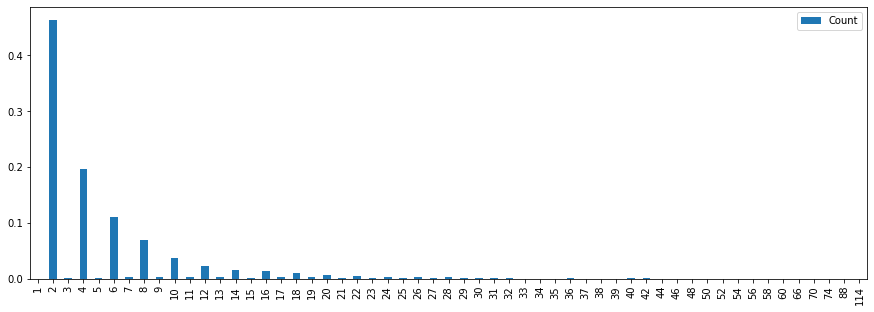

In [ ]:
aux = pd.DataFrame((data.groupby(['Case ID','Activity'])
                       .AMOUNT_REQ.count())
                       .reset_index()
                       .rename(columns={'AMOUNT_REQ':'Count'}))
_ = pd.DataFrame(aux.Count.value_counts().sort_index()/aux.shape[0]).plot(kind='bar', figsize=(15,5))

# Cálculo da duração das atividades (custo no MDP)

In [ ]:
data['time:timestamp'] = pd.to_datetime(data['time:timestamp'], format="%d/%m/%Y %H:%M:%S")

In [ ]:
data = data.sort_values(['Case ID','Activity','org:resource','time:timestamp'])
data.head()

,Case ID,Activity,AMOUNT_REQ,REG_DATE,org:resource,lifecycle:transition,time:timestamp
134,173703,W_Filling in information for the application,13500,01/10/2011 09:45:25,10912.0,START,2011-10-01 11:37:46
135,173703,W_Filling in information for the application,13500,01/10/2011 09:45:25,10912.0,COMPLETE,2011-10-01 11:40:24
136,173703,W_Filling in information for the application,13500,01/10/2011 09:45:25,10912.0,START,2011-10-01 12:40:26
138,173703,W_Filling in information for the application,13500,01/10/2011 09:45:25,10912.0,COMPLETE,2011-10-01 13:02:12
157,173709,W_Filling in information for the application,11000,01/10/2011 09:57:42,10912.0,START,2011-10-01 10:26:42


In [ ]:
def calc_duration(x):
  if (x['lifecycle:transition'] == 'COMPLETE' and 
      x['lifecycle:transition_shifted'] == 'START' and 
      x['Activity_shifted'] == x['Activity'] and
      x['org:resource_shifted'] == x['org:resource']):
    return x['time:timestamp'] - x['time:timestamp_shifted']
  return np.nan

In [ ]:
data['lifecycle:transition_shifted'] = data['lifecycle:transition'].shift()
data['Activity_shifted'] = data['Activity'].shift()
data['org:resource_shifted'] = data['org:resource'].shift()
data['time:timestamp_shifted'] = data['time:timestamp'].shift()
data['duration'] = data.apply(calc_duration, axis=1)
data['Duration(s)'] = data.duration.apply(lambda x: pd.Timedelta(x).total_seconds())

# Criar resources' workload

In [ ]:
qtd_resources = len(data['org:resource'].unique())
qtd_resources

57

In [ ]:
data['Workload_count'] = [{int(resource): 0 for resource in data['org:resource'].unique()}]*len(data)
data.head(3)

,Case ID,Activity,AMOUNT_REQ,REG_DATE,org:resource,lifecycle:transition,time:timestamp,lifecycle:transition_shifted,Activity_shifted,org:resource_shifted,time:timestamp_shifted,duration,Duration(s),Workload_count
134,173703,W_Filling in information for the application,13500,01/10/2011 09:45:25,10912.0,START,2011-10-01 11:37:46,NaN,NaN,NaN,NaT,NaT,NaN,"{10912: 0, 10982: 0, 11019: 0, 11180: 0, 10939..."
135,173703,W_Filling in information for the application,13500,01/10/2011 09:45:25,10912.0,COMPLETE,2011-10-01 11:40:24,START,W_Filling in information for the application,10912.0,2011-10-01 11:37:46,0 days 00:02:38,158.0,"{10912: 0, 10982: 0, 11019: 0, 11180: 0, 10939..."
136,173703,W_Filling in information for the application,13500,01/10/2011 09:45:25,10912.0,START,2011-10-01 12:40:26,COMPLETE,W_Filling in information for the application,10912.0,2011-10-01 11:40:24,NaT,NaN,"{10912: 0, 10982: 0, 11019: 0, 11180: 0, 10939..."


In [ ]:
RESOURCES_WORKLOAD = {int(resource): 0 for resource in data['org:resource'].unique()}
def update_workload_count(x):
  if x['lifecycle:transition'] == 'START': 
    RESOURCES_WORKLOAD[int(x['org:resource'])] += 1
  elif x['lifecycle:transition'] == 'COMPLETE' and RESOURCES_WORKLOAD[int(x['org:resource'])] > 0:
    RESOURCES_WORKLOAD[int(x['org:resource'])] -= 1
  x.Workload_count = RESOURCES_WORKLOAD.copy()
  return x

In [ ]:
data = data.sort_values(by='time:timestamp').apply(lambda x: update_workload_count(x), axis=1)

In [ ]:
def def_workload_status(x):
  activities_being_exec = np.array(list(x['Workload_count'].values())).sum()
  AVG_R = (activities_being_exec/qtd_resources) 
  def get_r_workload(resource):
    if x['Workload_count'][resource] < 1:
      return 'FREE'
    elif x['Workload_count'][resource] <= AVG_R: 
      return 'LOW'
    return 'HIGH' 
  x['Workload'] = {resource: get_r_workload(resource) for resource in x['Workload_count']}
  return x
data = data.apply(lambda x: def_workload_status(x), axis=1)
#nesse cj de dados, acaba sendo sempre 'FREE' ou 'HIGH' porque são poucas atividades executadas 
#num mesmo intervalo de tempo -> fica bem pequena a média de atividades em cada r, como a maioria
#executa 0 atividades - activities_being_exec é pequeno e qtd_resources é grande (57).

Excluindo as atividades de início (START) e as que não tem evento de início (já que a duration delas vai estar vazio)

In [ ]:
data.shape

(69924, 15)

In [ ]:
data = data.dropna()
data.shape

(34751, 15)

In [ ]:
data_final = data[['Case ID', 'Activity', 'org:resource', 'Workload', 'Duration(s)']]
data_final['org:resource'] = data_final['org:resource'].astype(int).astype(str)
data_final = data_final.rename(columns = {'org:resource':'Resource'})
data_final

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Case ID,Activity,Resource,Workload,Duration(s)
171,173712,W_Fixing incoming lead,10912,"{10912: 'FREE', 10982: 'FREE', 11019: 'FREE', ...",109.0
158,173709,W_Filling in information for the application,10912,"{10912: 'FREE', 10982: 'FREE', 11019: 'FREE', ...",25.0
135,173703,W_Filling in information for the application,10912,"{10912: 'FREE', 10982: 'FREE', 11019: 'FREE', ...",158.0
160,173709,W_Filling in information for the application,10912,"{10912: 'FREE', 10982: 'FREE', 11019: 'FREE', ...",142.0
138,173703,W_Filling in information for the application,10912,"{10912: 'FREE', 10982: 'FREE', 11019: 'HIGH', ...",1306.0
...,...,...,...,...,...
246921,211624,W_Calling to add missing information to the ap...,10863,"{10912: 'FREE', 10982: 'FREE', 11019: 'FREE', ...",161.0
259482,213855,W_Calling after sent offers,11203,"{10912: 'FREE', 10982: 'FREE', 11019: 'FREE', ...",505.0
252823,212689,W_Calling to add missing information to the ap...,10863,"{10912: 'FREE', 10982: 'FREE', 11019: 'FREE', ...",163.0
256159,213276,W_Calling to add missing information to the ap...,10863,"{10912: 'FREE', 10982: 'FREE', 11019: 'FREE', ...",41.0


Uma visualização rápida da duração das atividades por recurso:

In [ ]:
df2plot = data_final.groupby(['Resource','Activity'])['Duration(s)'].mean().reset_index()
df2plot['Resource'] = "r_" + df2plot['Resource'].astype(int).astype(str)

In [ ]:
import plotly.express as px
px.bar(df2plot, x='Resource', y = 'Duration(s)', color = 'Activity', barmode = 'group', 
       template='plotly_white', width = 1200, height = 400).show()

# Salvar conjunto de dados final

In [ ]:
data_final.to_csv('bpi12_preprocessed.csv',index=False)
from google.colab import files
files.download('bpi12_preprocessed.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>